In [1]:
import tensorflow as tf
import numpy as np
import scipy.io
import timeit
import sys
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import random
import seaborn as sns
import pandas as pd
import mpmath

The analytical solution (Srivastava and Yeh, 1991) is based on the following constituitive relationships:
\begin{equation}
K_* = K_s e^{\alpha \psi},
\end{equation}

\begin{equation}
\theta = \theta_r + (\theta_s - \theta_r) e^{\alpha \psi},
\end{equation}
where $K_s$ is the saturated hydraulic conductivity, $\theta_r$ is the residual water content, $\theta_s$ is the saturated water content, $\alpha$ is a pore-size distribution parameter. Using the constituitive relationships, the RRE is linearlized.

Dimensionless parameters are introduced:
\begin{equation}
z = \alpha_1 z_* \text{   for   } -L_{*1} \leq z_* \leq 0,
\end{equation}

\begin{equation}
z = \alpha_2 z_* \text{   for   } 0 \leq z_* \leq L_{*2},
\end{equation}

\begin{equation}
K_1 = K_{*1}/K_{s1},  q_{A1} = q_{A*}/K_{s1},  q_{B} = q_{B*}/K_{s1},
\end{equation}

\begin{equation}
K_2 = K_{*2}/K_{s2},  q_{A2} = q_{A*}/K_{s2},  q_{B} = q_{B*}/K_{s2},
\end{equation}

\begin{equation}
t = \frac{\alpha_1 K_{s1}t_*}{\theta_{s1} - \theta_{r1}}.
\end{equation}

The governing equations are:
\begin{equation}
\frac{\partial^2 K_1}{\partial z^2} + \frac{\partial K_1}{\partial z} = \frac{\partial K_1}{\partial t},
\end{equation}

\begin{equation}
\frac{\partial^2 K_2}{\partial z^2} + \frac{\partial K_2}{\partial z} = \beta\frac{\partial K_2}{\partial t},
\end{equation}
where 
\begin{equation}
\beta = \frac{\alpha_1 K_{s1}(\theta_{s2} - \theta_{r2})}{\alpha_2 K_{s2}(\theta_{s1} - \theta_{r1})}.
\end{equation}

In [2]:
# define computational domain
dom_coords_1 = np.array([[0.0, 0.0],   # t = 0 hour to t = 10 hours
                       [10.0, -10.0]])  # domain 1 is the lower layer

dom_coords_2 = np.array([[0.0, 10.0],   # t = 0 hour to t = 10 hours
                       [10.0, 0.0]])   # domain 2 is the upper layer

In [5]:
t_star = np.linspace(dom_coords_1[0, 0], dom_coords_1[1, 0], 101)[:, None]
z1_star = np.linspace(dom_coords_1[0, 1], dom_coords_1[1, 1], 101)[:, None]
z2_star = np.linspace(dom_coords_2[0, 1], dom_coords_2[1, 1], 101)[:, None]

In [6]:
# parameter values
alpha1 = 1.0 # /cm
alpha2 = 1.0 # /cm
K_s1 = 1.0 # cm/hour
K_s2 = 10.0 # cm/hour
theta_s1 = 0.40
theta_s2 = 0.40
theta_r1 = 0.06
theta_r2 = 0.06
L1_star = 10.0 # cm
L2_star = 10.0 # cm

In [9]:
# transformation
L1 = L1_star * alpha1
L2 = L2_star * alpha2
z1 = z1_star * alpha1
z2 = z2_star * alpha2

t = alpha1 * K_s1 * t_star/(theta_s1 - theta_r1)

In [8]:
# suface water flux condition (positive downward) [cm/hour]
q_A1_star = 0.1
q_A2_star = 0.1
q_B1_star = 0.9
q_B2_star = 0.9

# pressure at the lower boundary (water table)
psi_0 = 0.0

q_A1 = q_A1_star / K_s1
q_A2 = q_A2_star / K_s2
q_B1 = q_B1_star / K_s1
q_B2 = q_B2_star / K_s2

# initial condition for the lower layer
K_1_ini = q_A1 - (q_A1 - np.exp(alpha1 * psi_0)) * np.exp(-(L1 + z1))
psi_1_ini = np.log(K_1_ini) /alpha1

In [10]:
t1_mesh, z1_mesh = np.meshgrid(t, z1)
t2_mesh, z2_mesh = np.meshgrid(t, z2)

In [14]:
# initial condition for the upper layer
K_2_ini = q_A2 - (q_A2 - (q_A1 - (q_A1 - np.exp(alpha1 * psi_0)) \
       *np.exp(-L1))**(alpha2/alpha1))* np.exp(-z2)
psi_2_ini = np.log(K_2_ini) /alpha2

Text(0, 0.5, '$z$ cm')

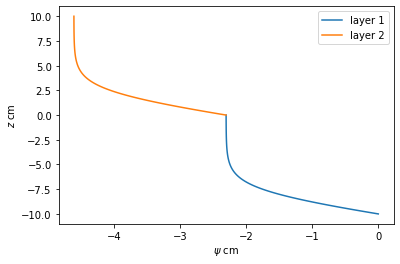

In [13]:
# initial condition
plt.plot(psi_1_ini, z1_star, label = "layer 1")
plt.plot(psi_2_ini, z2_star, label = "layer 2")
plt.legend()
plt.xlabel("$\psi$ cm")
plt.ylabel("$z$ cm")

In [15]:
# beta = 0.1 for this example, which means Case A and Case C are used for the analytical solution
beta = (alpha1 * K_s1 * (theta_s2 - theta_r2))/ (alpha2 * K_s2 * (theta_s1 - theta_r1))
print("beta is", beta)

beta is 0.09999999999999999


Computing $RA_1$.
The values of $\lambda$ are obtained as the positive roots of the characteristic equation (21a).
we obtain $\lambda$ < 100 for higher accuracies for $t = 0.1$.

In [36]:
lam_test = np.arange(0.0, 100, 0.001)

In [ ]:
def residue_RA(lam):
    mu = (beta * lam**2 + (beta - 1.0)/4.0)**(1/2)
    A = np.sin(lam*L1) + 2*lam*np.cos(lam*L1)
    B = np.sin(mu*L2) + 2*mu*np.cos(mu*L2)
    C = (1 + 4*mu**2)*(K_s2/K_s1)*np.sin(lam*L1)*np.sin(mu*L2)
    return A * B - C

In [37]:
# two sign changes: one is due to discontinuity, and the other one is the root
pd.set_option('display.max_rows', None)
data = {"lam": lam_test.flatten()[0:-1], 
        "sign": np.sign(residue_RA(lam_test)).flatten()[0:-1],
        "change": np.sign(residue_RA(lam_test)).flatten()[0:-1] - np.sign(residue_RA(lam_test)).flatten()[1:]}
df = pd.DataFrame(data)

C:\Users\toshi\anaconda3\envs\tensorflow1\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  
C:\Users\toshi\anaconda3\envs\tensorflow1\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sign
  after removing the cwd from sys.path.
C:\Users\toshi\anaconda3\envs\tensorflow1\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sign
  """


In [39]:
# the roots can be found near where the sign changes
a_set = df.loc[np.abs(df["change"]) == 2]["lam"].values

In [44]:
# program to find roots using Newton method (solver = 'newton')


def residue_RA(lam):
    mu = (beta * lam**2 + (beta - 1.0)/4.0)**(1/2)
    A = mpmath.sin(lam*L1) + 2*lam*mpmath.cos(lam*L1)
    B = mpmath.sin(mu*L2) + 2*mu*mpmath.cos(mu*L2)
    C = (1 + 4*mu**2)*(K_s2/K_s1)*mpmath.sin(lam*L1)*mpmath.sin(mu*L2)
    return A * B - C

roots = []

for a in a_set[0:]:  # change the argument to find roots if you encounter errors
    a = int(a/0.001)
    for i in range(a, a + 5):
        print(i)
        initial_value = 0.001 * (i + 1)
        root = mpmath.findroot(residue_RA, initial_value, solver = 'newton')
        root_value = np.array(root, np.float).tolist()
        roots.append(root_value)

1599
1600
1601
1602
1603
1788
1789
1790
1791
1792
1932
1933
1934
1935
1936
2210
2211
2212
2213
2214
2441
2442
2443
2444
2445
2588
2589
2590
2591
2592
2849
2850
2851
2852
2853
3128
3129
3130
3131
3132
3326
3327
3328
3329
3330
3508
3509
3510
3511
3512
3783
3784
3785
3786
3787
4057
4058
4059
4060
4061
4250
4251
4252
4253
4254
4445
4446
4447
4448
4449
4722
4723
4724
4725
4726
4997
4998
4999
5000
5001
5190
5191
5192
5193
5194
5387
5388
5389
5390
5391
5663
5664
5665
5666
5667
5940
5941
5942
5943
5944
6140
6141
6142
6143
6144
6332
6333
6334
6335
6336
6607
6608
6609
6610
6611
6886
6887
6888
6889
6890
7095
7096
7097
7098
7099
7280
7281
7282
7283
7284
7551
7552
7553
7554
7555
7832
7833
7834
7835
7836
8051
8052
8053
8054
8055
8230
8231
8232
8233
8234
8496
8497
8498
8499
8500
8778
8779
8780
8781
8782
9011
9012
9013
9014
9015
9183
9184
9185
9186
9187
9441
9442
9443
9444
9445
9725
9726
9727
9728
9729
9969
9970
9971
9972
9973
10138
10139
10140
10141
10142
10388
10389
10390
10391
10392
10671
10672
106

84170
84171
84172
84173
84174
84402
84403
84404
84405
84406
84576
84577
84578
84579
84580
84835
84836
84837
84838
84839
85119
85120
85121
85122
85123
85366
85367
85368
85369
85370
85536
85537
85538
85539
85540
85783
85784
85785
85786
85787
86067
86068
86069
86070
86071
86326
86327
86328
86329
86330
86499
86500
86501
86502
86503
86732
86733
86734
86735
86736
87015
87016
87017
87018
87019
87283
87284
87285
87286
87287
87465
87466
87467
87468
87469
87682
87683
87684
87685
87686
87962
87963
87964
87965
87966
88237
88238
88239
88240
88241
88433
88434
88435
88436
88437
88633
88634
88635
88636
88637
88909
88910
88911
88912
88913
89188
89189
89190
89191
89192
89401
89402
89403
89404
89405
89586
89587
89588
89589
89590
89856
89857
89858
89859
89860
90138
90139
90140
90141
90142
90367
90368
90369
90370
90371
90542
90543
90544
90545
90546
90803
90804
90805
90806
90807
91087
91088
91089
91090
91091
91331
91332
91333
91334
91335
91502
91503
91504
91505
91506
91751
91752
91753
91754
91755
92035
9203

In [45]:
set(roots)

{1.5990891427798726,
 1.788732691327088,
 1.932914344549613,
 2.2109110956513467,
 2.4419555167035885,
 2.5885848998466656,
 2.849989333932118,
 3.1281660491170373,
 3.3263461862747836,
 3.5089830748945015,
 3.783396450018647,
 4.0587499327999375,
 4.2500096554362,
 4.445555964175939,
 4.722261597342127,
 4.997520330348105,
 5.190937232329985,
 5.3875852765189185,
 5.663899469930367,
 5.940709869938875,
 6.140596614835184,
 6.33275567156643,
 6.607129174713171,
 6.886060588985002,
 7.095209499312184,
 7.280401466688491,
 7.551376030390238,
 7.8323370399311925,
 8.052565867522132,
 8.23044450603,
 8.49636374147896,
 8.778910896574448,
 9.011039166201218,
 9.1830697482723,
 9.441983167272015,
 9.725494441337466,
 9.969322368562036,
 10.138530274048614,
 10.388233654920867,
 10.671982483467206,
 10.926434114796178,
 11.096952757076904,
 11.335200046561987,
 11.618363938254081,
 11.881795898316074,
 12.05816134199271,
 12.283050046645862,
 12.564675538325883,
 12.83524123901948,
 13.021599

In [46]:
# these roots are obtained through Newton's method
RA_roots = [1.5990891427798726,
 1.788732691327088,
 1.932914344549613,
 2.2109110956513467,
 2.4419555167035885,
 2.5885848998466656,
 2.849989333932118,
 3.1281660491170373,
 3.3263461862747836,
 3.5089830748945015,
 3.783396450018647,
 4.0587499327999375,
 4.2500096554362,
 4.445555964175939,
 4.722261597342127,
 4.997520330348105,
 5.190937232329985,
 5.3875852765189185,
 5.663899469930367,
 5.940709869938875,
 6.140596614835184,
 6.33275567156643,
 6.607129174713171,
 6.886060588985002,
 7.095209499312184,
 7.280401466688491,
 7.551376030390238,
 7.8323370399311925,
 8.052565867522132,
 8.23044450603,
 8.49636374147896,
 8.778910896574448,
 9.011039166201218,
 9.1830697482723,
 9.441983167272015,
 9.725494441337466,
 9.969322368562036,
 10.138530274048614,
 10.388233654920867,
 10.671982483467206,
 10.926434114796178,
 11.096952757076904,
 11.335200046561987,
 11.618363938254081,
 11.881795898316074,
 12.05816134199271,
 12.283050046645862,
 12.564675538325883,
 12.83524123901948,
 13.021599981161451,
 13.232043976029324,
 13.510979803646782,
 13.78691103995045,
 13.986383685492326,
 14.182548338021387,
 14.457356685210335,
 14.737099288791287,
 14.951422765861851,
 15.135035478146149,
 15.403903238899153,
 15.686131192623376,
 15.915568038428134,
 16.09003453791654,
 16.35073878569254,
 16.63430083057258,
 16.87778792031103,
 17.04799247320583,
 17.298014892620287,
 17.5818530423035,
 17.837380305311136,
 18.009054889969647,
 18.245930540189043,
 18.528987245914934,
 18.794120668749507,
 18.97288575406163,
 19.194752835079072,
 19.475868961286285,
 19.748223167244905,
 19.938664451417566,
 20.144841261296854,
 20.422642802130465,
 20.700146618147762,
 20.905243784142034,
 21.096665490613677,
 21.36944521522357,
 21.65039765714026,
 21.871345260135367,
 22.050789185647496,
 22.316417308981585,
 22.59942216949087,
 22.83574787378633,
 23.007771571246685,
 23.26371901522057,
 23.547575723690084,
 23.79750807013827,
 23.967956594247525,
 24.211546230341284,
 24.495132983115276,
 24.75617125425975,
 24.93122756072884,
 25.160152468257767,
 25.442308614647423,
 25.711820575470526,
 25.896908812003076,
 26.109874943073603,
 26.38927822657481,
 26.66490500841016,
 26.863889556692698,
 27.061159119294334,
 27.33619656983615,
 27.615993811847783,
 27.830846095936195,
 28.014560849029866,
 28.283213658512377,
 28.565612463776073,
 28.796451204805997,
 28.970681191280395,
 29.23049057513832,
 29.514184601227317,
 29.759593065890563,
 29.929984806172033,
 30.17821705395824,
 30.462034619984344,
 30.719614250741852,
 30.892534456195584,
 31.126632864304202,
 31.40941075106034,
 31.676435610144512,
 31.857815694621625,
 32.07605391991435,
 32.35650997438538,
 32.63043881838727,
 32.82479975070046,
 33.026899688846825,
 33.303499500645344,
 33.5822062485808,
 33.792166497675645,
 33.97970628209389,
 34.250534985713415,
 34.532310974256845,
 34.75853318936432,
 34.9350861979419,
 35.197777341476126,
 35.481226092576726,
 35.72267335845731,
 35.89357884497937,
 36.145410432352826,
 36.42931503958064,
 36.68376431788118,
 36.85538911756186,
 37.093661935009315,
 37.376853342894364,
 37.641566154759616,
 37.82015879203966,
 38.0428288886042,
 38.32405564700252,
 38.59636827681748,
 38.78696222224,
 38.993306217048676,
 39.2710995220295,
 39.54873872479654,
 39.75451084722061,
 39.945606643276214,
 40.218145296597775,
 40.499279680878274,
 40.72139638545084,
 40.90033907234792,
 41.16535366141217,
 41.448503469395185,
 41.68631256019343,
 41.85808912541147,
 42.1129034130371,
 42.39680718255687,
 42.648302000506234,
 42.819174289219866,
 43.06101176135671,
 43.344490768519194,
 43.6069728126568,
 43.7833820332885,
 44.00995911201846,
 44.291784989158856,
 44.56250882104887,
 44.74990063619678,
 44.960117802384424,
 45.23887702049473,
 45.51544495342708,
 45.71749157319881,
 45.91197633558676,
 46.185931679348194,
 46.46639939369378,
 46.68474077765222,
 46.866131814599285,
 47.13310975153132,
 47.415916915687504,
 47.65028593541643,
 47.82319709880706,
 48.080585800164926,
 48.364425182999994,
 48.61305905456402,
 48.783578851174276,
 49.0285679637308,
 49.31224720988233,
 49.57252672412086,
 49.74719827622644,
 49.977321910123365,
 50.259629311327394,
 50.52875921312127,
 50.71336333188308,
 50.92719928775875,
 51.20676812274482,
 51.48224356648535,
 51.680899329614626,
 51.87866465525323,
 52.15383310023448,
 52.4336031467763,
 52.648401016127465,
 52.83229855812179,
 53.10098556555707,
 53.38340988653587,
 53.61446737441787,
 53.78872776035599,
 54.04839662812041,
 54.33212001649836,
 54.57793918434023,
 54.748429047040915,
 54.99626654235868,
 55.28007903144342,
 55.53815235637299,
 55.711445050649495,
 55.94484783996595,
 56.22754875066923,
 56.4950587870766,
 56.67720610669772,
 56.8944732101477,
 57.17473544232577,
 57.449085073822914,
 57.644612558834176,
 57.84558402295245,
 58.121813522455895,
 58.4008498688213,
 58.612279882020026,
 58.79874145803496,
 59.06894533675702,
 59.350947530622044,
 59.578781823129134,
 59.7545764538522,
 60.01629925881578,
 60.29986134642249,
 60.542884027117346,
 60.713620046805545,
 60.96406868532684,
 61.24795911639664,
 61.50380262689339,
 61.676023944667456,
 61.91249438662608,
 62.19551841306711,
 62.46136864171307,
 62.64134130386411,
 62.8618916535012,
 63.14275550063443,
 63.41593714946038,
 63.60855696756366,
 63.81267964411834,
 64.08985017439029,
 64.36811250891209,
 64.57631762116566,
 64.76539855955836,
 65.03696631214747,
 65.31850683423295,
 65.5431828535302,
 65.72067625259793,
 65.9842702171477,
 66.26762912605196,
 66.50785686580033,
 66.67908458680958,
 66.93194933306637,
 67.21586952957189,
 67.46944687957124,
 67.64087207368169,
 67.88023387086244,
 68.16352180241984,
 68.42766247629135,
 68.6057132399554,
 68.82942313625892,
 69.11081269241872,
 69.38277739295187,
 69.57268550444225,
 69.7799151533709,
 70.05792785859981,
 70.33537213436817,
 70.54047645948188,
 70.73222831541355,
 71.0050332299864,
 71.28607167243781,
 71.50764112724117,
 71.68698192099966,
 71.95229366389803,
 72.23540934023758,
 72.47283414486189,
 72.64477721778965,
 72.89989146346213,
 73.18379776109897,
 73.43506458325183,
 73.60594743653633,
 73.84804734874952,
 74.13154742502378,
 74.3939217650586,
 74.57028533634853,
 74.79704592914061,
 75.07889613888426,
 75.34958948807117,
 75.53696768075024,
 75.74726521343875,
 76.02603595823757,
 76.30261476934344,
 76.5047322008677,
 76.69920149521533,
 76.97313539084057,
 77.25363013473333,
 77.47213803750353,
 77.65346140629822,
 77.92035844148852,
 78.20319168541128,
 78.4378007424199,
 78.61066580783138,
 78.86788301438096,
 79.15173466413779,
 79.40064180921354,
 79.57122086961452,
 79.81592130214112,
 80.09958691145333,
 80.36013305822898,
 80.53503292480471,
 80.76474440122267,
 81.04699793457125,
 81.31636104116674,
 81.50138351083318,
 81.7147114319083,
 81.99416675772241,
 82.26982959889115,
 82.46906939375938,
 82.66629667635232,
 82.94126500360997,
 83.22117299241245,
 83.43666200148992,
 83.62009104391728,
 83.88845639514504,
 84.17096823030235,
 84.4027471837285,
 84.57672669165763,
 84.83591512414371,
 85.11967325672309,
 85.3661691539245,
 85.53667137760691,
 85.7838457349754,
 86.06763391882056,
 86.32628639822366,
 86.49993900343861,
 86.73250690473772,
 87.01511211670491,
 87.2830823081631,
 87.46591989204883,
 87.68223998088733,
 87.9623144498927,
 88.23700790009333,
 88.43347841180586,
 88.6334975954157,
 88.90941620232971,
 89.1886927772784,
 89.40120619350648,
 89.5868527194551,
 89.85658136967506,
 90.13873260495185,
 90.36766791836288,
 90.54294177220034,
 90.803981074716,
 91.0876079921273,
 91.33164045612156,
 91.50228330110585,
 91.75181302405834,
 92.03568345897374,
 92.29237435358041,
 92.4649916181877,
 92.7003244914274,
 92.98323403147752,
 93.24974541871431,
 93.43056834472881,
 93.649840144344,
 93.93047452271378,
 94.20414238242675,
 94.39795361566829,
 94.60079152284162,
 94.87758443608601,
 95.15618320580225,
 95.36576710207841,
 95.55373211896544,
 95.82472858419692,
 96.10647948952229,
 96.33256020946943,
 96.50929672332327,
 96.77207563016299,
 97.055534296444,
 97.29705197058009,
 97.4680445358772,
 97.71981719652074,
 98.00373147096346,
 98.25839141022159,
 98.43018218489864,
 98.66819010184345,
 98.95135992922364,
 99.21634389178443,
 99.39532354569985,
 99.61750339646373,
 99.89864336603767]

In [50]:
# redifine residue_RA for plotting
def residue_RA(lam):
    mu = (beta * lam**2 + (beta - 1.0)/4.0)**(1/2)
    A = np.sin(lam*L1) + 2*lam*np.cos(lam*L1)
    B = np.sin(mu*L2) + 2*mu*np.cos(mu*L2)
    C = (1 + 4*mu**2)*(K_s2/K_s1)*np.sin(lam*L1)*np.sin(mu*L2)
    return A * B - C

C:\Users\toshi\anaconda3\envs\tensorflow1\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


(-0.25, 0.25)

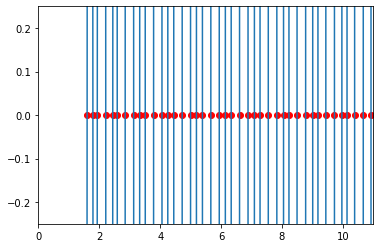

In [51]:
# check if there are no missing roots
plt.plot(lam_test, residue_RA(lam_test))
plt.scatter(RA_roots, residue_RA(np.array(RA_roots)), c = 'r')
plt.xlim(0, 11)
plt.ylim(-.25, .25)

C:\Users\toshi\anaconda3\envs\tensorflow1\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


(-0.25, 0.25)

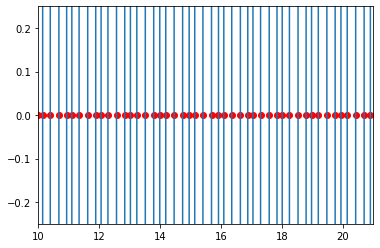

In [21]:
plt.plot(lam_test, residue_RA(lam_test))
plt.scatter(RA_roots, residue_RA(np.array(RA_roots)), c = 'r')
plt.xlim(10, 21)
plt.ylim(-.25, .25)

C:\Users\toshi\anaconda3\envs\tensorflow1\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


(-0.25, 0.25)

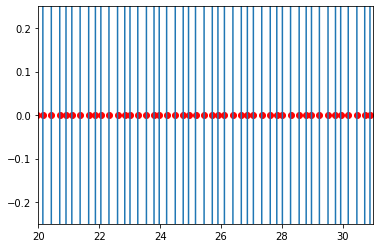

In [22]:
plt.plot(lam_test, residue_RA(lam_test))
plt.scatter(RA_roots, residue_RA(np.array(RA_roots)), c = 'r')
plt.xlim(20, 31)
plt.ylim(-.25, .25)

C:\Users\toshi\anaconda3\envs\tensorflow1\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


(-0.25, 0.25)

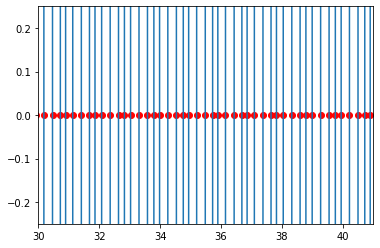

In [23]:
plt.plot(lam_test, residue_RA(lam_test))
plt.scatter(RA_roots, residue_RA(np.array(RA_roots)), c = 'r')
plt.xlim(30, 41)
plt.ylim(-.25, .25)

C:\Users\toshi\anaconda3\envs\tensorflow1\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


(-0.25, 0.25)

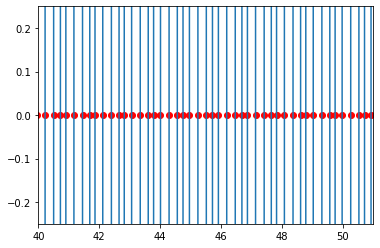

In [24]:
plt.plot(lam_test, residue_RA(lam_test))
plt.scatter(RA_roots, residue_RA(np.array(RA_roots)), c = 'r')
plt.xlim(40, 51)
plt.ylim(-.25, .25)

C:\Users\toshi\anaconda3\envs\tensorflow1\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


(-0.25, 0.25)

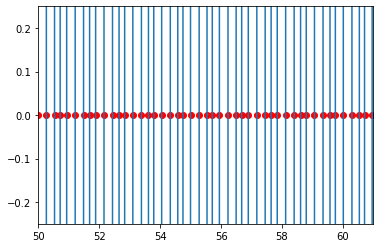

In [25]:
plt.plot(lam_test, residue_RA(lam_test))
plt.scatter(RA_roots, residue_RA(np.array(RA_roots)), c = 'r')
plt.xlim(50, 61)
plt.ylim(-.25, .25)

C:\Users\toshi\anaconda3\envs\tensorflow1\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


(-0.25, 0.25)

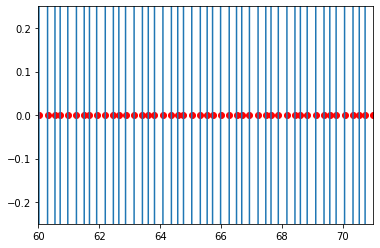

In [26]:
plt.plot(lam_test, residue_RA(lam_test))
plt.scatter(RA_roots, residue_RA(np.array(RA_roots)), c = 'r')
plt.xlim(60, 71)
plt.ylim(-.25, .25)

C:\Users\toshi\anaconda3\envs\tensorflow1\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


(-0.25, 0.25)

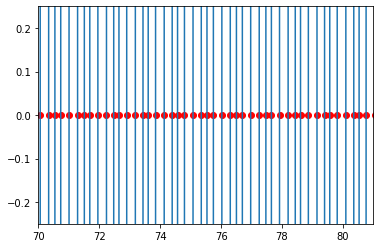

In [27]:
plt.plot(lam_test, residue_RA(lam_test))
plt.scatter(RA_roots, residue_RA(np.array(RA_roots)), c = 'r')
plt.xlim(70, 81)
plt.ylim(-.25, .25)

C:\Users\toshi\anaconda3\envs\tensorflow1\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


(-0.25, 0.25)

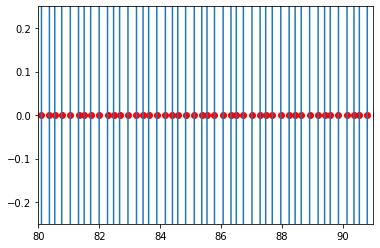

In [28]:
plt.plot(lam_test, residue_RA(lam_test))
plt.scatter(RA_roots, residue_RA(np.array(RA_roots)), c = 'r')
plt.xlim(80, 91)
plt.ylim(-.25, .25)

C:\Users\toshi\anaconda3\envs\tensorflow1\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


(-0.25, 0.25)

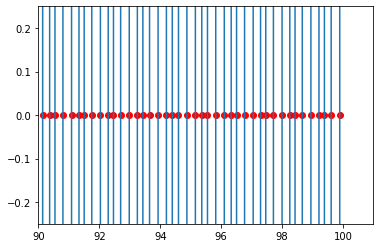

In [29]:
plt.plot(lam_test, residue_RA(lam_test))
plt.scatter(RA_roots, residue_RA(np.array(RA_roots)), c = 'r')
plt.xlim(90, 101)
plt.ylim(-.25, .25)

In [52]:
residue_RA(np.array(RA_roots))

array([-9.32587341e-15,  1.48769885e-14, -5.32907052e-15, -8.88178420e-15,
        8.88178420e-15, -6.21724894e-15, -4.88498131e-14,  8.88178420e-15,
        8.12683254e-14,  1.10134124e-13, -1.87405647e-13, -5.32907052e-15,
        4.27435864e-14, -9.59232693e-14, -7.65609798e-13,  1.38555833e-13,
        3.52384788e-13, -1.77635684e-13,  5.25801624e-13,  5.36459765e-13,
        9.01501096e-14, -3.19744231e-13,  1.09423581e-12, -3.76587650e-13,
        4.45865567e-13, -3.33955086e-13,  7.06990022e-13, -8.52651283e-14,
        1.42819090e-12, -1.12265752e-12,  4.61852778e-13,  7.81597009e-13,
       -1.66977543e-12, -7.10542736e-13, -1.38555833e-12, -2.32347475e-12,
       -1.00897068e-12, -2.41584530e-12,  2.81374923e-12, -1.22213351e-12,
        3.25428573e-12, -1.64845915e-12, -1.63424829e-12,  9.69890834e-13,
       -3.90798505e-12,  2.57216470e-12, -3.95061761e-12, -4.99156272e-13,
       -1.13686838e-13,  5.69144731e-12,  5.31485966e-12, -7.97051314e-12,
        5.05906428e-12,  

In [53]:
# summation in Equation 22a and 22b in their paper (Srivastva and Yeh, 1991)
RA1 = np.zeros(t1_mesh.shape)
RA2 = np.zeros(t2_mesh.shape)

for root in RA_roots:
    mu = (beta*root**2 + (beta - 1.0)/4.0)**(1/2)
    A_ss = 4 * beta * root *K_s2/K_s1 + root*(L1 + beta* L2)
    A_sc = K_s2/K_s1*(beta * root * L2)/(2*mu)*(1 + 4*mu**2) + 2*root*mu*L1- (beta * root)/(2*mu)*(2 + L2)
    A_cs = K_s2/K_s1*L1/2*(1 + 4*mu**2) + 2*beta*root**2*L2 - 1.0 - L1/2.0
    A_cc = -mu*(2.0 + L1) - beta*root**2/mu*(2.0 + L2)

    D_n = (1/4 + root**2)/(mu*root)* \
         (A_ss*np.sin(root*L1)*np.sin(mu*L2) + \
          A_sc*np.sin(root*L1)*np.cos(mu*L2) + \
          A_cs*np.cos(root*L1)*np.sin(mu*L2) + \
          A_cc*np.cos(root*L1)*np.cos(mu*L2))
        
    RA1 += np.sin(root*(L1 + z1_mesh))*np.exp(-(1/4 + root**2)*t1_mesh)/D_n
    RA2 += (np.sin(root*L1) * (np.sin(mu*(L2 - z2_mesh)) + 2*mu*np.cos(mu*(L2 - z2_mesh)))\
            * np.exp(-(1/4 + root**2)*t2_mesh))/(D_n * (np.sin(mu*L2) + 2*mu*np.cos(mu*L2))) 

In the example, $\beta = 0.1$ and thus we only use Case C. Also, Because $(\frac{1 - \beta}{4})^{1/2} = 0.4743...$, we only take into accout of $\lambda < 0.474$.

In [80]:
((1 - beta)/(4))**(1/2)

0.4743416490252569

In [55]:
lam_test = np.arange(0, 0.474, 0.001)

In [58]:
# two sign changes: one is due to discontinuity, and the other one is the root
pd.set_option('display.max_rows', None)
data = {"lam": lam_test.flatten()[0:-1], 
        "sign": np.sign(residue_RC(lam_test)).flatten()[0:-1],
        "change": np.sign(residue_RC(lam_test)).flatten()[0:-1] - np.sign(residue_RC(lam_test)).flatten()[1:]}
df = pd.DataFrame(data)

a_set = df.loc[np.abs(df["change"]) == 2]["lam"].values

In [59]:
# program to find roots using Newton method

def residue_RC(mu):
    lam = ((1 - beta)/(4*beta) - mu**2/beta)**(1/2)
    
    A = mpmath.sin(lam*L1) + 2*lam*mpmath.cos(lam*L1)
    B = mpmath.sinh(mu*L2) + 2*mu*mpmath.cosh(mu*L2)
    C = (1 - 4*mu**2)*(K_s2/K_s1)*mpmath.sin(lam*L1)*mpmath.sinh(mu*L2)
    return A * B - C



roots = []

for a in a_set:
    a = int(a/0.001)
    for i in range(a, a + 10):
        print(i)
        initial_value = 0.001 * (i + 1)
        root = mpmath.findroot(residue_RC, initial_value, solver = 'newton')
        root_value = np.array(root, np.float).tolist()
        roots.append(root_value)

230
231
232
233
234
235
236
237
238
239
347
348
349
350
351
352
353
354
355
356
412
413
414
415
416
417
418
419
420
421
450
451
452
453
454
455
456
457
458
459
468
469
470
471
472


ValueError: Could not find root within given tolerance. (993.821483019300822846 > 2.16840434497100886801e-19)
Try another starting point or tweak arguments.

In [60]:
set(roots)

{0.23059017983575425,
 0.34753161404921556,
 0.41281772029876773,
 0.4502656328080065,
 0.46889797480709333}

In [61]:
# these roots are obtained through Newton's method
RC_roots = [
0.23059017983575425,
 0.34753161404921556,
 0.41281772029876773,
 0.4502656328080065,
 0.46889797480709333
]

In [63]:
# redifine for the plotting
def residue_RC(mu):
    lam = ((1 - beta)/(4*beta) - mu**2/beta)**(1/2)
    
    A = np.sin(lam*L1) + 2*lam*np.cos(lam*L1)
    B = np.sinh(mu*L2) + 2*mu*np.cosh(mu*L2)
    C = (1 - 4*mu**2)*(K_s2/K_s1)*np.sin(lam*L1)*np.sinh(mu*L2)
    return A * B - C

(-0.25, 0.25)

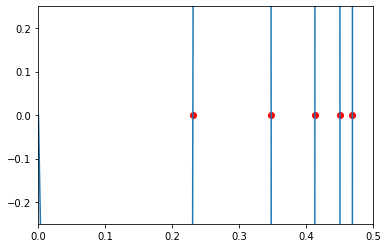

In [64]:
plt.plot(lam_test, residue_RC(lam_test))
plt.scatter(RC_roots, residue_RC(np.array(RC_roots)), c = 'r')
plt.xlim(0, 0.5)
plt.ylim(-.25, .25)

In [65]:
residue_RC(np.array(RC_roots))

array([ 5.32907052e-14,  1.91846539e-13, -7.10542736e-14,  9.94759830e-14,
        1.84741111e-13])

In [66]:
# summation in Equation 28a and 28b in their paper (Srivastva and Yeh, 1991)
RC1 = np.zeros(t1_mesh.shape)
RC2 = np.zeros(t2_mesh.shape)

for mu in RC_roots:
    root = ((1 - beta)/(4*beta) - mu**2/beta)**(1/2)
    C_ss = 4 * beta * root *K_s2/K_s1 + root*(L1 + beta* L2)
    C_sc = -K_s2/K_s1*(beta * root * L2)/(2*mu)*(1 - 4*mu**2) + 2*root*mu*L1 + (beta * root)/(2*mu)*(2 + L2)
    C_cs = K_s2/K_s1*L1/2*(1 - 4*mu**2) + 2*beta*root**2*L2 - 1.0 - L1/2.0
    C_cc = -mu*(2.0 + L1) + beta*root**2/mu*(2 + L2)

    D_n = (1/4 + root**2)/(mu*root)* \
         (C_ss*np.sin(root*L1)*np.sinh(mu*L2) + \
          C_sc*np.sin(root*L1)*np.cosh(mu*L2) + \
          C_cs*np.cos(root*L1)*np.sinh(mu*L2) + \
          C_cc*np.cos(root*L1)*np.cosh(mu*L2))
        
    RC1 += np.sin(root*(L1 + z1_mesh))*np.exp(-(1/4 + root**2)*t1_mesh)/D_n
    RC2 += (np.sin(root*L1) * (np.sinh(mu*(L2 - z2_mesh)) + 2*mu*np.cosh(mu*(L2 - z2_mesh)))\
            * np.exp(-(1/4 + root**2)*t2_mesh))/(D_n * (np.sinh(mu*L2) + 2*mu*np.cosh(mu*L2))) 

In [67]:
# Equation 30a and 30b in their paper (Srivastva and Yeh, 1991)
# note the analytical solution assumes alpha1 = alpha2

K_1 = q_B1 - (q_B1 - np.exp(alpha1 * psi_0)) * np.exp(-(L1 + z1_mesh)) \
      - 4 * (q_B1 - q_A1) * np.exp((L2 - z1_mesh)/2) * (RA1 + RC1)

K_2 = q_B2 - (q_B2 - q_B1 + (q_B1 - np.exp(alpha2 * psi_0)) * np.exp(-L1)) * np.exp(-z2_mesh) \
      - 4 * (q_B1 - q_A1) * np.exp((L2 - z2_mesh)/2) * (RA2 + RC2)
                            

In [68]:
# transformation
K_1_star = K_1 * K_s1
K_2_star = K_2 * K_s2
psi_1 = np.log(K_1_star/K_s1)/alpha1
psi_2 = np.log(K_2_star/K_s2)/alpha2

In [69]:
psi_ini = np.concatenate((psi_2_ini, psi_1_ini), axis = 0)
z_star = np.concatenate((z2_star, z1_star), axis = 0)
psi = np.concatenate((psi_2, psi_1), axis = 0)

In [72]:
# the initial condition is used for the solution at t = 0 because the numerical solution is unstable at t = 0.
psi[:, 0] = psi_ini.flatten()

(-10, 10)

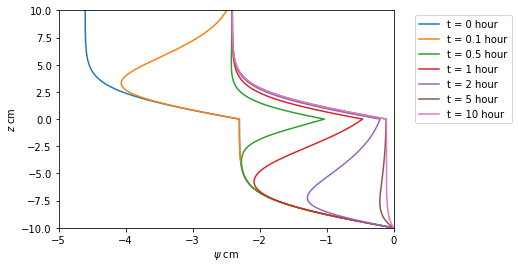

In [75]:
plt.plot(psi[:, 0], z_star, label = "t = 0 hour")
plt.plot(psi[:, 1], z_star, label = "t = 0.1 hour")
plt.plot(psi[:, 5], z_star, label = "t = 0.5 hour")
plt.plot(psi[:, 10], z_star, label = "t = 1 hour")
plt.plot(psi[:, 20], z_star, label = "t = 2 hour")
plt.plot(psi[:, 50], z_star, label = "t = 5 hour")
plt.plot(psi[:, 100], z_star, label = "t = 10 hour")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',)
plt.xlabel("$\\psi$ cm")
plt.ylabel("$z$ cm")
plt.xlim(-5, 0)
plt.ylim(-10, 10)

In [77]:
# save solutions
# psi: each column for each time (0, 0.1, 0.2, ..., 10 hours)
# each row for each depth (10, 9.9, ..., -10.0 cm)

In [78]:
# numpy format
np.save("Srivastava_psi_heterogeneous", psi)
# matlab format
matlab_data = {'data':psi}
scipy.io.savemat("Srivastava_psi_heterogeneous", matlab_data)